# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [1]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce
import squarify

# Functions

In [2]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

In [3]:
def str_id(gpd_df):
    """
    Function makes a new col with a unique lat-lon string to identify each osm point & drops duplicates
    Function also makes
    """

    
    print(gpd_df.shape)
    
    lat_string = gpd_df.lat.astype(str)
    lon_string = gpd_df.lon.astype(str)
    gpd_df['str_id'] = lat_string.astype(str)+lon_string.astype(str)
    
    print(gpd_df.shape)


In [4]:
def dup_drop(gpd_in, col, keep_dup):
    """ 
    function drops duplicates based on a column from a pd data frame
    requires pd df out string, pd df, col name, and which dup to keep
    returns new gpd_df
    """
    
    gpd_out = gpd.GeoDataFrame()
    
    print(gpd_in.shape)
    
    gpd_out = gpd_in.drop_duplicates(col, keep = keep_dup)
    
    print(gpd_out.shape)

    return gpd_out

    

In [5]:
def df_merge(df_left, df_right):
    
    pd_out = pd.DataFrame()
    pd_out = pd.merge(df_left[['str_id', 'PopTot']], df_right[['str_id', 'PopTot']], on='str_id', how = 'inner')
    
    left_pop = pd_out.PopTot_x.astype(str)
    right_pop = pd_out.PopTot_y.astype(str)
    pd_out['pop_id'] = left_pop.astype(str)+right_pop.astype(str)

    return pd_out

In [6]:
def p_X_gt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data>=x)/n_data for x in X ])

def p_X_lt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data<=x)/n_data for x in X ])

# Data

In [7]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [8]:
# Data

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

In [9]:
# List of datasets

datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

In [10]:
GHS2000.head(6)

,osm_id,FID,country,city,osm_type,lat,lon,PopTot,aez_class,geometry
0,89369215,5382,Algeria,Tamanrasset,town,22.785454,5.532446,3.091468e+04,Tropic - cool / arid,"POLYGON ((5.512930562910484 22.80475188764244,..."
1,252600742,624,Algeria,Boumerdès,town,36.758882,3.470596,4.041199e+06,Subtropic - warm / subhumid,"POLYGON ((2.960095682991406 36.82071885667166,..."
2,253167052,195,Algeria,Thenia,town,36.724986,3.556935,2.767512e+04,Subtropic - warm / subhumid,"POLYGON ((3.610972972741118 36.75033076389462,..."
3,253167208,150,Algeria,Zemmouri,town,36.786406,3.601221,2.016720e+04,Subtropic - warm / subhumid,"POLYGON ((3.555512812300016 36.81191901602259,..."
4,253291208,436,Algeria,Lakhdaria,town,36.563944,3.596907,4.186613e+04,Subtropic - warm / subhumid,"POLYGON ((3.548917172615572 36.58325611006445,..."
5,253292622,257,Algeria,Draâ Ben Khedda,town,36.733332,3.958769,3.400638e+05,Subtropic - warm / subhumid,"POLYGON ((3.842424792309737 36.82951907750196,..."


### Add regions

Add new column that adds the region for each city

In [11]:
### List of African Countries from the UN in OSM wiki

Northern_Africa = (['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Western Sahara'], 'Northern_Africa')

Eastern_Africa = ([
    'Burundi',
    'Comoros',
    'Djibouti',
    'Eritrea',
    'Ethiopia',
    'Kenya',
    'Madagascar',
    'Malawi',
    'Mauritius',
    #Mayotte,
    'Mozambique',
    'Réunion',
    'Rwanda',
    'Somalia',
    'Sudan',
    'Uganda',
    'Tanzania',
    'Zambia',
    'Zimbabwe'], 'Eastern_Africa')
    
Middle_Africa = ([
    'Angola',
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Congo-Brazzaville',
    'Congo-Kinshasa',
    'Equatorial Guinea',
    'Gabon',
    'Sao Tome and Principe'], 'Middle_Africa')
    
Southern_Africa = ([
    'Botswana',
    'Lesotho',
    'Namibia',
    'South Africa',
    'Swaziland'], 'Southern_Africa')
    
Western_Africa = ([
    'Benin',
    'Burkina Faso',
    'Cape Verde',
    'Côte d\'Ivoire',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Liberia',
    'Mali',
    'Mauritania',
    'Niger',
    'Nigeria',
    'Senegal',
    'Sierra Leone',
    'Togo'], 'Western_Africa')

In [12]:
regions = [Northern_Africa, Western_Africa, Eastern_Africa, Southern_Africa, Middle_Africa]

In [13]:
def region(gpd_df, regions_list):
    "Function adds a new col to a df based on region"
    arr =[]
    for region in regions_list:
        for country in region[0]:
            for i, row in gpd_df.iterrows():
                if row['country'] == country:
                    #row['region'] = region[1] 
                    #df_copy.iloc[i] = row
                    #region[1]
                    arr.append(region[1])
    gpd_df['region'] = arr
    
    return gpd_df

In [14]:
for dataset in datasets_in:
    dataset = region(dataset, regions)

###  AZE to Rain Zones

create new column for each dataset that includes a cities rain climate 

In [15]:
# Group my rainfall zone

arid = (['Temperate / arid', 
         'Subtropic - warm / arid', 
         'Subtropic - cool / arid', 
         'Tropic - warm / arid',
         'Tropic - cool / arid'], 'Arid')

semi_arid = (['Temperate / Semi-arid', 
              'Subtropic - warm / semiarid', 
              'Subtropic - cool / semiarid',
              'Tropic - warm / semiarid', 
              'Tropic - cool / semiarid'], 'Semi-arid')    

sub_humid = (['Temperate / sub-humid', 
              'Subtropic - warm / subhumid', 
              'Subtropic - cool / subhumid',
              'Tropic - warm / subhumid', 
              'Tropic - cool / subhumid'], 'Sub-humid')

humid = (['Temperate / humid', 
          'Subtropic - warm / humid', 
          'Subtropic - cool / humid', 
          'Tropic - warm / humid',
          'Tropic - cool / humid'], 'Humid')

boreal = (['Boreal'], 'Boreal')

na = (['NoClass', '0'], 'NA')

rain_list = [arid, semi_arid, sub_humid, humid, boreal, na]

In [16]:
def rain_zone(gpd_df, rain_list):
    "function adds a new col to a gpd_df based on rain fall zone"
    arr =[]
    for rain_zone in rain_list:
        for aez in rain_zone[0]:
            for i, row in gpd_df.iterrows():
                if row['aez_class'] == aez:
                    arr.append(rain_zone[1])
                
    gpd_df['rain_zone'] = arr
    
    return gpd_df

In [17]:
for dataset in datasets_in:
    dataset = rain_zone(dataset, rain_list)

### Drop duplicates & >5000

In [18]:
# Drop Duplicate FIDs (Polygons) and <5000 people 

print('1---WP2015---') # World Pop 2015

# drop FID
print(len(WP2015))
WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
print(len(WP2015))

# drop <5000
WP2015 = WP2015[WP2015['PopTot'] > 5000]
print(len(WP2015))

print('2---LS2015---') # LandScan 2015
# drop FID
print(len(LS2015))
LS2015 = LS2015.drop_duplicates('FID', keep = 'first')
print(len(LS2015))

# drop <5000
LS2015 = LS2015[LS2015['PopTot'] > 5000]
print(len(LS2015))

print('3---WPE2016---') # WPE 2016
# drop FID
print(len(WPE2016))
WPE2016 = WPE2016.drop_duplicates('FID', keep = 'first')
print(len(WPE2016))

# drop <5000
WPE2016 = WPE2016[WPE2016['PopTot'] > 5000]
print(len(WPE2016))

print('4---GHS2015---') # GHS 2015
# drop FID
print(len(GHS2015))
GHS2015 = GHS2015.drop_duplicates('FID', keep = 'first')
print(len(GHS2015))

# drop <5000
GHS2015 = GHS2015[GHS2015['PopTot'] > 5000]
print(len(GHS2015))

print('5---GHS2000---') # GHS 2000
# drop FID
print(len(GHS2000))
GHS2000 = GHS2000.drop_duplicates('FID', keep = 'first')
print(len(GHS2000))

# drop <5000
GHS2000 = GHS2000[GHS2000['PopTot'] > 5000]
print(len(GHS2000))

      
print('6---WP2000---') # World Pop 2000

# drop FID
print(len(WP2000))
WP2000 = WP2000.drop_duplicates('FID', keep = 'first')
print(len(WP2000))

# drop <5000
WP2000 = WP2000[WP2000['PopTot'] > 5000]
print(len(WP2000))

1---WP2015---
3854
2616
2411
2---LS2015---
5598
4217
3801
3---WPE2016---
5552
4347
3643
4---GHS2015---
6229
5026
4162
5---GHS2000---
5854
4951
3858
6---WP2000---
3152
2259
2061


### Chunk by Rain Zone

For GHS 2000 and 2015 ... replace variables and run through twice.

In [19]:
GHS2015.rain_zone.unique()

array(['Arid', 'Semi-arid', 'Sub-humid', 'Humid', 'NA'], dtype=object)

In [27]:
# Chunk by country 

GHS2000_arid = GHS2000[GHS2000['rain_zone'] == 'Arid']
GHS2000_semi = GHS2000[GHS2000['rain_zone'] == 'Semi-arid']
GHS2000_sub = GHS2000[GHS2000['rain_zone'] == 'Sub-humid']
GHS2000_humid = GHS2000[GHS2000['rain_zone'] == 'Humid']

In [28]:
# GHS 2000 Arid Chunks 
GHS2000_arid_50k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_arid_50k)

GHS2000_arid_100k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**4) & (GHS2000_arid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_arid_100k)

GHS2000_arid_250k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 10**5) & (GHS2000_arid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_arid_250k)

GHS2000_arid_500k = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 2.5*10**5) & (GHS2000_arid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_arid_500k)

GHS2000_arid_1m = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**5) & (GHS2000_arid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_arid_1m)

GHS2000_arid_5m = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 10**6) & (GHS2000_arid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_arid_5m)

GHS2000_arid_5mplus = GHS2000_arid.loc[(GHS2000_arid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_arid_5mplus)

6173531.4839782715
2467822.3436584473
2015448.934753418
1754416.781097412
2201014.4514160156
5543261.00982666
41848377.25411987


In [29]:
# GHS Semi Arid Chunks 
GHS2000_semi_50k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_semi_50k)

GHS2000_semi_100k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**4) & (GHS2000_semi['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_semi_100k)

GHS2000_semi_250k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 10**5) & (GHS2000_semi['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_semi_250k)

GHS2000_semi_500k = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 2.5*10**5) & (GHS2000_semi['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_semi_500k)

GHS2000_semi_1m = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**5) & (GHS2000_semi['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_semi_1m)

GHS2000_semi_5m = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 10**6) & (GHS2000_semi['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_semi_5m)

GHS2000_semi_5mplus = GHS2000_semi.loc[(GHS2000_semi['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_semi_5mplus)

20078591.0
10738163.031402588
10441807.781768799
2501755.6067199707
7727270.320068359
24003578.77685547
8025210.592407227


In [30]:
# GHS Sub Humid Chunks 
GHS2000_sub_50k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_sub_50k)

GHS2000_sub_100k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**4) & (GHS2000_sub['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_sub_100k)

GHS2000_sub_250k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 10**5) & (GHS2000_sub['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_sub_250k)

GHS2000_sub_500k = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 2.5*10**5) & (GHS2000_sub['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_sub_500k)

GHS2000_sub_1m = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**5) & (GHS2000_sub['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_sub_1m)

GHS2000_sub_5m = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 10**6) & (GHS2000_sub['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_sub_5m)

GHS2000_sub_5mplus = GHS2000_sub.loc[(GHS2000_sub['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_sub_5mplus)

23311424.843719482
11070931.20248413
11718018.308105469
9155597.179870605
5647804.123626709
42385958.82962036
5141828.90625


In [31]:
# GHS Humid Chunks 
GHS2000_humid_50k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_humid_50k)

GHS2000_humid_100k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**4) & (GHS2000_humid['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_humid_100k)

GHS2000_humid_250k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 10**5) & (GHS2000_humid['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_humid_250k)

GHS2000_humid_500k = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 2.5*10**5) & (GHS2000_humid['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_humid_500k)

GHS2000_humid_1m = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**5) & (GHS2000_humid['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_humid_1m)

GHS2000_humid_5m = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 10**6) & (GHS2000_humid['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_humid_5m)

GHS2000_humid_5mplus = GHS2000_humid.loc[(GHS2000_humid['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_humid_5mplus)

5496692.309661865
8696881.815429688
16743555.248077393
12506906.578277588
6714256.68939209
3450173.637359619
0.0


In [32]:
# GHS 2000
GHS2000_arid_bar = {'<50K':GHS2000_arid_50k, '50-100K': GHS2000_arid_100k, '100-150K':GHS2000_arid_250k,
    '250-500K' : GHS2000_arid_500k, '500K-1M' : GHS2000_arid_1m, '1-5M' : GHS2000_arid_5m, '>5M' : GHS2000_arid_5mplus
             }

GHS2000_semi_bar = {u'Label0':GHS2000_semi_50k, u'Label1': GHS2000_semi_100k, u'Label2':GHS2000_semi_250k,
    u'Label3' : GHS2000_semi_500k, u'Label4' : GHS2000_semi_1m, u'Label5' : GHS2000_semi_5m, u'Label6' : GHS2000_semi_5mplus
    }

GHS2000_sub_bar = {u'Label0':GHS2000_sub_50k, u'Label1': GHS2000_sub_100k, u'Label2':GHS2000_sub_250k,
    u'Label3' : GHS2000_sub_500k, u'Label4' : GHS2000_sub_1m, u'Label5' : GHS2000_sub_5m, u'Label6' : GHS2000_sub_5mplus
    }

GHS2000_humid_bar = {u'Label0':GHS2000_humid_50k, u'Label1': GHS2000_humid_100k, u'Label2':GHS2000_humid_250k,
    u'Label3' : GHS2000_humid_500k, u'Label4' : GHS2000_humid_1m, u'Label5' : GHS2000_humid_5m, u'Label6' : GHS2000_humid_5mplus
   }

In [26]:
# GHS 2015
GHS2015_arid_bar = {'<50K':GHS2015_arid_50k, '50-100K': GHS2015_arid_100k, '100-150K':GHS2015_arid_250k,
    '250-500K' : GHS2015_arid_500k, '500K-1M' : GHS2015_arid_1m, '1-5M' : GHS2015_arid_5m, '>5M' : GHS2015_arid_5mplus
             }

GHS2015_semi_bar = {u'Label0':GHS2015_semi_50k, u'Label1': GHS2015_semi_100k, u'Label2':GHS2015_semi_250k,
    u'Label3' : GHS2015_semi_500k, u'Label4' : GHS2015_semi_1m, u'Label5' : GHS2015_semi_5m, u'Label6' : GHS2015_semi_5mplus
    }

GHS2015_sub_bar = {u'Label0':GHS2015_sub_50k, u'Label1': GHS2015_sub_100k, u'Label2':GHS2015_sub_250k,
    u'Label3' : GHS2015_sub_500k, u'Label4' : GHS2015_sub_1m, u'Label5' : GHS2015_sub_5m, u'Label6' : GHS2015_sub_5mplus
    }

GHS2015_humid_bar = {u'Label0':GHS2015_humid_50k, u'Label1': GHS2015_humid_100k, u'Label2':GHS2015_humid_250k,
    u'Label3' : GHS2015_humid_500k, u'Label4' : GHS2015_humid_1m, u'Label5' : GHS2015_humid_5m, u'Label6' : GHS2015_humid_5mplus
   }

### Rain Zone Pct Change

In [ ]:
arid_2000 = [GHS2000_arid_50k, GHS2000_arid_100k, GHS2000_arid_250k, GHS2000_arid_500k, GHS2000_arid_1m,
            GHS2000_arid_5m, GHS2000_arid_5mplus]

arid_2000_pct = np.round(arid_2000 / GHS2000.PopTot.sum() * 100, 1)

In [ ]:
semi_2000 = [GHS2000_semi_50k, GHS2000_semi_100k, GHS2000_semi_250k, GHS2000_semi_500k, GHS2000_semi_1m,
            GHS2000_semi_5m, GHS2000_semi_5mplus]

semi_2000_pct = np.round(semi_2000 / GHS2000.PopTot.sum() * 100, 1)
semi_2000_pct 

In [ ]:
sub_2000 = [GHS2000_sub_50k, GHS2000_sub_100k, GHS2000_sub_250k, GHS2000_sub_500k, GHS2000_sub_1m,
            GHS2000_sub_5m, GHS2000_sub_5mplus]

sub_2000_pct = np.round(sub_2000 / GHS2000.PopTot.sum() * 100, 1)
sub_2000_pct 

In [ ]:
humid_2000 = [GHS2000_humid_50k, GHS2000_humid_100k, GHS2000_humid_250k, GHS2000_humid_500k, GHS2000_humid_1m,
            GHS2000_humid_5m, GHS2000_humid_5mplus]

humid_2000_pct = np.round(humid_2000 / GHS2000.PopTot.sum() * 100, 1)
humid_2000_pct 

In [ ]:
arid_2015 = [GHS2015_arid_50k, GHS2015_arid_100k, GHS2015_arid_250k, GHS2015_arid_500k, GHS2015_arid_1m,
            GHS2015_arid_5m, GHS2015_arid_5mplus]

arid_2015_pct = np.round(arid_2015 / GHS2015.PopTot.sum() * 100, 1)
arid_2015_pct 

In [ ]:
semi_2015 = [GHS2015_semi_50k, GHS2015_semi_100k, GHS2015_semi_250k, GHS2015_semi_500k, GHS2015_semi_1m,
            GHS2015_semi_5m, GHS2015_semi_5mplus]

semi_2015_pct = np.round(semi_2015 / GHS2015.PopTot.sum() * 100, 1)
semi_2015_pct 

In [ ]:
sub_2015 = [GHS2015_sub_50k, GHS2015_sub_100k, GHS2015_sub_250k, GHS2015_sub_500k, GHS2015_sub_1m,
            GHS2015_sub_5m, GHS2015_sub_5mplus]

sub_2015_pct = np.round(sub_2015 / GHS2015.PopTot.sum() * 100, 1)
sub_2015_pct 

In [ ]:
humid_2015 = [GHS2015_humid_50k, GHS2015_humid_100k, GHS2015_humid_250k, GHS2015_humid_500k, GHS2015_humid_1m,
            GHS2015_humid_5m, GHS2015_humid_5mplus]

humid_2015_pct = np.round(humid_2015 / GHS2015.PopTot.sum() * 100, 1)
humid_2015_pct 

### Pct Change by Rainfall Zone

In [ ]:
# [a_i - b_i for a_i, b_i in zip(a, b)]

arid_delt = [(((a - b)/b)*100) for a, b in zip(arid_2015, arid_2000)]
semi_delt = [(((a - b)/b)*100) for a, b in zip(semi_2015, semi_2000)]
sub_delt = [(((a - b)/b)*100) for a, b in zip(sub_2015, sub_2000)]
humid_delt = [(((a - b)/b)*100) for a, b in zip(humid_2015[0:6], humid_2000[0:6])]


print(len(humid_delt))
humid_delt.append(0)
print(len(humid_delt))

In [ ]:
# Make some plots

# make plot
sns.set(font_scale=1.5)

a = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
b = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
c = [0,1,2,3,4,5,6]
d = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]


# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(a, arid_delt, width=0.2, align='center', alpha  = 0.7, color = 'Blue')
plt.bar(b, semi_delt, width=0.2, align='center', alpha  = 0.7, color = 'Purple')
plt.bar(c, sub_delt, width=0.2, align='center', alpha  = 0.7, color = 'Red')
plt.bar(d, humid_delt, width=0.2, align='center', alpha = 0.7, color = 'Green')

bar_leg = ['Arid', 'Semi-arid', 'Sub-humid', 'Humid']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 9)
#plt.gca().set_yscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.title('Percent Change in GHS-Pop 2000 - 2015 by Rainfall Zone')
ax.set_facecolor('White')
fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_bar.png', dpi=700, transparent=False)



In [ ]:
# Break up by Rain Zone 2000

GHS2000_rain = GHS2000[GHS2000['rain_zone'] != '0']
GHS2000_rain = GHS2000_rain[GHS2000_rain['rain_zone'] != 'NoClass']
GHS2000_rain =  GHS2000_rain[GHS2000_rain['rain_zone'] != 'NA']
GHS2000_rain['raincat'] = GHS2000_rain.rain_zone + ' 2000'

# Break up by Rain Zone 2015 & add unique col 
GHS2015_rain = GHS2015[GHS2015['rain_zone'] != '0']
GHS2015_rain = GHS2015_rain[GHS2015_rain['rain_zone'] != 'NoClass']
GHS2015_rain =  GHS2015_rain[GHS2015_rain['rain_zone'] != 'NA']
GHS2015_rain['raincat'] = GHS2015_rain.rain_zone + ' 2015'

# Join the two
datasets_rain = [GHS2000_rain, GHS2015_rain]
datasets_rain_concat = pd.concat(datasets_rain, ignore_index=True)


In [ ]:
sns.set(font_scale=1)

plot_order = ['Arid 2000', 'Arid 2015', 'Semi-arid 2000', 'Semi-arid 2015',
              'Sub-humid 2000', 'Sub-humid 2015', 'Humid 2000', 'Humid 2015']

pal = ['Blue', 'Blue', 'Purple', 'Purple', 'Red', 'Red', 'Green', 'Green']

ax = sns.boxplot(x = 'PopTot', y = 'raincat', data = datasets_rain_concat, order = plot_order, palette = pal, 
                 sym = '')


# Add transparency to colors
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .7))


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4.5, 3)
plt.gca().set_xscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution by Moisture Zone 2000 & 2015', x = 0.25)
ax.set_facecolor('White')
#fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_box.png', dpi=700, transparent=False,
#           bbox_inches='tight')

In [ ]:
round(datasets_rain_concat.groupby(['raincat']).PopTot.std())

### Chunk by Dataset 

In [ ]:
# WP 2015 Chunks
WP2015_50k = WP2015.loc[(WP2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2015_50k)

WP2015_100k = WP2015.loc[(WP2015['PopTot'] > 5*10**4) & (WP2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2015_100k)

WP2015_250k = WP2015.loc[(WP2015['PopTot'] > 10**5) & (WP2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2015_250k)

WP2015_500k = WP2015.loc[(WP2015['PopTot'] > 2.5*10**5) & (WP2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2015_500k)

WP2015_1m = WP2015.loc[(WP2015['PopTot'] > 5*10**5) & (WP2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2015_1m)

WP2015_5m = WP2015.loc[(WP2015['PopTot'] > 10**6) & (WP2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2015_5m)

WP2015_5mplus = WP2015.loc[(WP2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2015_5mplus)

In [ ]:
# LS 2015 Chunks 

LS2015_50k = LS2015.loc[(LS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(LS2015_50k)

LS2015_100k = LS2015.loc[(LS2015['PopTot'] > 5*10**4) & (LS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(LS2015_100k)

LS2015_250k = LS2015.loc[(LS2015['PopTot'] > 10**5) & (LS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(LS2015_250k)

LS2015_500k = LS2015.loc[(LS2015['PopTot'] > 2.5*10**5) & (LS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(LS2015_500k)

LS2015_1m = LS2015.loc[(LS2015['PopTot'] > 5*10**5) & (LS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(LS2015_1m)

LS2015_5m = LS2015.loc[(LS2015['PopTot'] > 10**6) & (LS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(LS2015_5m)

LS2015_5mplus = LS2015.loc[(LS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(LS2015_5mplus)

In [ ]:
#GHS 2015 Chunks

GHS2015_50k = GHS2015.loc[(GHS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_50k)

GHS2015_100k = GHS2015.loc[(GHS2015['PopTot'] > 5*10**4) & (GHS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_100k)

GHS2015_250k = GHS2015.loc[(GHS2015['PopTot'] > 10**5) & (GHS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_250k)

GHS2015_500k = GHS2015.loc[(GHS2015['PopTot'] > 2.5*10**5) & (GHS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_500k)

GHS2015_1m = GHS2015.loc[(GHS2015['PopTot'] > 5*10**5) & (GHS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_1m)

GHS2015_5m = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_5m)

GHS2015_5mplus = GHS2015.loc[(GHS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_5mplus)

In [ ]:
# WPE 2016 Chunks
WPE2016_50k = WPE2016.loc[(WPE2016['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WPE2016_50k)

WPE2016_100k = WPE2016.loc[(WPE2016['PopTot'] > 5*10**4) & (WPE2016['PopTot'] <= 10**5), 'PopTot'].sum()
print(WPE2016_100k)

WPE2016_250k = WPE2016.loc[(WPE2016['PopTot'] > 10**5) & (WPE2016['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WPE2016_250k)

WPE2016_500k = WPE2016.loc[(WPE2016['PopTot'] > 2.5*10**5) & (WPE2016['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WPE2016_500k)

WPE2016_1m = WPE2016.loc[(WPE2016['PopTot'] > 5*10**5) & (WPE2016['PopTot'] <= 10**6), 'PopTot'].sum()
print(WPE2016_1m)

WPE2016_5m = WPE2016.loc[(WPE2016['PopTot'] > 10**6) & (WPE2016['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WPE2016_5m)

WPE2016_5mplus = WPE2016.loc[(WPE2016['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WPE2016_5mplus)

In [ ]:
# WP 2000 Chunks
WP2000_50k = WP2000.loc[(WP2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2000_50k)

WP2000_100k = WP2000.loc[(WP2000['PopTot'] > 5*10**4) & (WP2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2000_100k)

WP2000_250k = WP2000.loc[(WP2000['PopTot'] > 10**5) & (WP2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2000_250k)

WP2000_500k = WP2000.loc[(WP2000['PopTot'] > 2.5*10**5) & (WP2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2000_500k)

WP2000_1m = WP2000.loc[(WP2000['PopTot'] > 5*10**5) & (WP2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2000_1m)

WP2000_5m = WP2000.loc[(WP2000['PopTot'] > 10**6) & (WP2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2000_5m)

WP2000_5mplus = WP2000.loc[(WP2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2000_5mplus)

In [ ]:
# GHS 2000 Chunks
GHS2000_50k = GHS2000.loc[(GHS2000['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2000_50k)

GHS2000_100k = GHS2000.loc[(GHS2000['PopTot'] > 5*10**4) & (GHS2000['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2000_100k)

GHS2000_250k = GHS2000.loc[(GHS2000['PopTot'] > 10**5) & (GHS2000['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2000_250k)

GHS2000_500k = GHS2000.loc[(GHS2000['PopTot'] > 2.5*10**5) & (GHS2000['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2000_500k)

GHS2000_1m = GHS2000.loc[(GHS2000['PopTot'] > 5*10**5) & (GHS2000['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2000_1m)

GHS2000_5m = GHS2000.loc[(GHS2000['PopTot'] > 10**6) & (GHS2000['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2000_5m)

GHS2000_5mplus = GHS2000.loc[(GHS2000['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2000_5mplus)

In [ ]:
# Chunks

WP2000_chunks = [WP2000_50k, WP2000_100k, WP2000_250k, WP2000_500k, WP2000_1m, WP2000_5m, WP2000_5mplus]
WP2015_chunks = [WP2015_50k, WP2015_100k, WP2015_250k, WP2015_500k, WP2015_1m, WP2015_5m, WP2015_5mplus]

GHS2000_chunks = [GHS2000_50k, GHS2000_100k, GHS2000_250k, GHS2000_500k, GHS2000_1m, GHS2000_5m, GHS2000_5mplus]
GHS2015_chunks = [GHS2015_50k, GHS2015_100k, GHS2015_250k, GHS2015_500k, GHS2015_1m, GHS2015_5m, GHS2015_5mplus]

LS2015_chunks = [LS2015_50k, LS2015_100k, LS2015_250k, LS2015_500k, LS2015_1m, LS2015_5m, LS2015_5mplus]

WPE2016_chunks = [WPE2016_50k, WPE2016_100k, WPE2016_250k, WPE2016_500k, WPE2016_1m, WPE2016_5m, WPE2016_5mplus]


In [ ]:
#datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

data_chunks = [GHS2000_chunks, GHS2015_chunks, WP2000_chunks, WP2015_chunks, LS2015_chunks, WPE2016_chunks] 

In [ ]:
# Percentages

GHS2000_chunks_pct = np.around(GHS2000_chunks / GHS2000.PopTot.sum() * 100, 1)
GHS2015_chunks_pct = np.around(GHS2015_chunks / GHS2015.PopTot.sum() * 100, 1)

WP2000_chunks_pct = np.around(WP2000_chunks / WP2000.PopTot.sum() * 100, 1)
WP2015_chunks_pct = np.around(WP2015_chunks / WP2015.PopTot.sum() * 100, 1)

LS2015_chunks_pct = np.around(LS2015_chunks / LS2015.PopTot.sum() * 100, 1)
WPE2016_chunks_pct = np.around(WPE2016_chunks / WPE2016.PopTot.sum() * 100, 1)

# Plots

### Bar plots

In [ ]:
# Total Change by Rain Zone

sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2015
plt.bar(x, GHS2015_arid_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, GHS2015_semi_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, GHS2015_sub_bar.values(), width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, GHS2015_humid_bar.values(), width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, GHS2000_arid_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, GHS2000_semi_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, GHS2000_sub_bar.values(), width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, GHS2000_humid_bar.values(), width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)

plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)



In [ ]:
# Pct Change by Rain Zone

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.22,1-.22,2-.22,3-.22,4-.22,5-.2,6-.22]
z = [0-.44,1-.44,2-.44,3-.44,4-.44,5-.44,6-.44]
a = [0+.22,1+.22,2+.22,3+.22,4+.22,5+.2,6+.22]

# Ticks
ticks_bar = ['<50K', '50-100K', '100-150K','250-500K', '500K-1M', '1-5M' , '>5M']


fig, ax = plt.subplots(nrows=1, ncols=1)

#2000
plt.bar(x, arid_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Blue')
plt.bar(y, semi_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Purple')
plt.bar(z, sub_2000_pct, width=0.2, align='center', alpha  = 0.3, color = 'Red')
plt.bar(a, humid_2000_pct, width=0.2, align='center', alpha = 0.3, color = 'Green')

#2000
plt.bar(x, arid_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Blue', edgecolor = 'Black')
plt.bar(y, semi_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Purple', edgecolor = 'Black')
plt.bar(z, sub_2015_pct, width=0.05, align='center', alpha  = 1, color = 'Red', edgecolor = 'Black')
plt.bar(a, humid_2015_pct, width=0.05, align='center', alpha = 1, color = 'Green', edgecolor = 'Black')

# bar_leg = ['WorldPop 2000 Arid', 'WorldPop 2000 Semi-arid', 'WorldPop 2000 Sub-humid', 'WorldPop 2000 Humid',
#           'WorldPop 2015 Arid', 'WorldPop 2015 Semi-arid', 'WorldPop 2015 Sub-humid', 'WorldPop 2015 Humid']

bar_leg = ['Arid', 'Semi']

plt.legend(bar_leg,loc=2)


plt.xticks(range(len(ticks_bar)), ticks_bar)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
#plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
ax.set_facecolor('White')
# fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)

In [ ]:
# Bar plot by Dataset 

import matplotlib.pyplot as plt

dictionary = plt.figure()

WP2015_bar = {'<50K':WP2015_50k, '50-100K': WP2015_100k, '100-150K':WP2015_250k,
    '250-500K' : WP2015_500k, '500K-1M' : WP2015_1m, '1-5M' : WP2015_5m, '>5M' : WP2015_5mplus
             }

# WP2000_bar = {u'Label0':WP2000_50k, u'Label1': WP2000_100k, u'Label2':WP2000_250k,
#     u'Label3' : WP2000_500k, u'Label4' : WP2000_1m, u'Label5' : WP2000_5m, u'Label6' : WP2000_5mplus
#     }

LS2015_bar = {u'Label0':LS2015_50k, u'Label1': LS2015_100k, u'Label2':LS2015_250k,
    u'Label3' : LS2015_500k, u'Label4' : LS2015_1m, u'Label5' : LS2015_5m, u'Label6' : LS2015_5mplus
    }

GHS2015_bar = {u'Label0':GHS2015_50k, u'Label1': GHS2015_100k, u'Label2':GHS2015_250k,
    u'Label3' : GHS2015_500k, u'Label4' : GHS2015_1m, u'Label5' : GHS2015_5m, u'Label6' : GHS2015_5mplus
    }

WPE2016_bar = {u'Label0':WPE2016_50k, u'Label1': WPE2016_100k, u'Label2':WPE2016_250k,
    u'Label3' : WPE2016_500k, u'Label4' : WPE2016_1m, u'Label5' : WPE2016_5m, u'Label6' : WPE2016_5mplus
   }

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.2,1-.2,2-.2,3-.2,4-.2,5-.2,6-.2]
z = [0-.4,1-.4,2-.4,3-.4,4-.4,5-.4,6-.4]
a = [0+.2,1+.2,2+.2,3+.2,4+.2,5+.2,6+.2]



plt.bar(x, WP2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Blue')

plt.bar(y, LS2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Green')
plt.bar(z, GHS2015_bar.values(), width=0.2, align='center', alpha  = 0.7, color = 'Orange')
plt.bar(a, WPE2016_bar.values(), width=0.2, align='center', alpha = 0.7, color = 'Purple')

bar_leg = ['WorldPop 2015', 'LandScan 2015', 'GHS-Pop 2015', 'ESRI-WPE 2016']
plt.legend(bar_leg,loc=2)



#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(WP2015_bar)), WP2015_bar.keys())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Urban Population by Settlement Size for Africa')
#fig.savefig('/Users/cascade/Desktop/'+'PopAll_bar.png', dpi=700, transparent=False)


# ax.bar(x-0.2, y,width=0.2,color='b',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')

### Square Plot

http://gvallver.perso.univ-pau.fr/?p=700

In [ ]:
print(np.around(LS2015_chunks))
print(LS2015_chunks_pct)

In [ ]:
# Make Data 

data = np.around(WPE2016_chunks)
pct = WPE2016_chunks_pct
chunks = ['<50K:', '50-100K: ', '100-150K: ','250-500K: ', '500K-1M: ', '1-5M: ', '>5M: ']

labels = [chunks[0]+'\n'+str(pct[0])+'%',
         chunks[1]+'\n'+str(pct[1])+'%',
         chunks[2]+'\n'+str(pct[2])+'%',
         chunks[3]+'\n'+str(pct[3])+'%',
         chunks[4]+'\n'+str(pct[4])+'%',
         chunks[5]+'\n'+str(pct[5])+'%',
         chunks[6]+'\n'+str(pct[6])+'%'
         ]


In [ ]:
# set size
sns.set(font_scale=1.5)

# Set Colors
norm = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
colors = [matplotlib.cm.Purples_r(norm(value)) for value in data]

# Create Plot
fig = plt.figure(figsize=(12, 10))
fig.suptitle("", fontsize=20)
ax = fig.add_subplot(111, aspect='equal')
ax1 = squarify.plot(data, color = colors, label=labels, ax=ax, alpha = 0.7)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('World Population Estimate 2016 \n Urban Settlments Distribution')

# color bar
bar_number = data/(10**6)

# create dummy invisible image with a color map
img = plt.imshow([bar_number], cmap='Purples_r')
img.set_visible(False)
fig.colorbar(img, orientation="vertical", shrink=.96)
fig.text(.76, .9, "Population in Millions", fontsize=14)

#fig.savefig('/Users/cascade/Desktop/'+'WPE2016_SquarePlot.png', dpi=700)


### Swarm Plots

In [90]:
# Data for Rain Zone Swarm Plot GHS 2015

# Break up by Rain Zone 2000

GHS2000_rain = GHS2000[GHS2000['rain_zone'] != '0']
GHS2000_rain = GHS2000_rain[GHS2000_rain['rain_zone'] != 'NoClass']
GHS2000_rain =  GHS2000_rain[GHS2000_rain['rain_zone'] != 'NA']
GHS2000_rain['raincat'] = GHS2000_rain.rain_zone + ' 2000'
GHS2000_rain['dataset'] = 'GHS2000'

# Break up by Rain Zone 2015 & add unique col 
GHS2015_rain = GHS2015[GHS2015['rain_zone'] != '0']
GHS2015_rain = GHS2015_rain[GHS2015_rain['rain_zone'] != 'NoClass']
GHS2015_rain =  GHS2015_rain[GHS2015_rain['rain_zone'] != 'NA']
GHS2015_rain['raincat'] = GHS2015_rain.rain_zone + ' 2015'
GHS2015_rain['dataset'] = 'GHS2015'


# Join the two
datasets_rain = [GHS2000_rain, GHS2015_rain]
datasets_rain_concat = pd.concat(datasets_rain, ignore_index=True)

In [54]:
test = GHS2000_rain
c = test.raincat
log = np.log(test.PopTot)

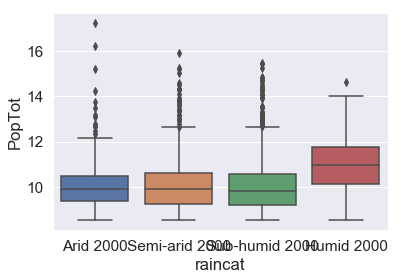

In [147]:
ax = sns.boxplot(x = c, y = log)
#plt.gca().set_yscale('log')



# sns.set_style("whitegrid")
# tips = sns.load_dataset("tips")
# ax = sns.swarmplot(x="day", y="total_bill", data=tips)
# ax = sns.boxplot(x="day", y="total_bill", data=tips,
#         showcaps=False,boxprops={'facecolor':'None'},
#         showfliers=False,whiskerprops={'linewidth':0})

# plt.show()

In [119]:
# make data with concat

test1 = datasets_rain_concat
c1 = test1.raincat
log1 = np.log(test1.PopTot)
group = datasets_rain_concat.dataset
country = datasets_rain_concat.country
region = datasets_rain_concat.region

d = {'cat': c1, 'log1': log1, 'group': group, 'country': country, 'region' : region}
df = pd.DataFrame(data=d)

df.head()

,cat,log1,group,country,region
0,Arid 2000,10.338986,GHS2000,Algeria,Northern_Africa
1,Arid 2000,15.212052,GHS2000,Algeria,Northern_Africa
2,Arid 2000,10.228289,GHS2000,Algeria,Northern_Africa
3,Arid 2000,9.911813,GHS2000,Algeria,Northern_Africa
4,Arid 2000,10.642232,GHS2000,Algeria,Northern_Africa


In [171]:
# make data by country

df1 = GHS2000.loc[GHS2000['country'].isin(['Senegal', 'Zambia','Nigeria','Kenya', 'Ghana', 'Mali', 'Ethiopia'])]

df1['group'] = 'GHS2000'
df1.head()

df2 = GHS2015.loc[GHS2015['country'].isin(['Senegal', 'Zambia','Nigeria','Kenya', 'Ghana', 'Mali', 'Ethiopia'])]
df2['group'] = 'GHS2015'
 
df_list = [df1, df2]

df = pd.concat(df_list, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


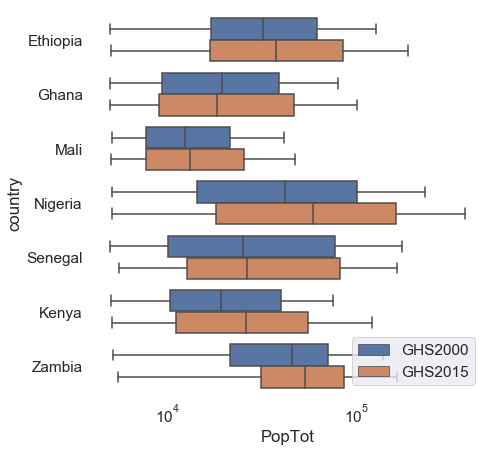

In [184]:
plot_order = ['Arid 2000', 'Arid 2015', 'Semi-arid 2000', 'Semi-arid 2015',
              'Sub-humid 2000', 'Sub-humid 2015', 'Humid 2000', 'Humid 2015']

sns.set(font_scale=1.4)
fig = plt.figure(figsize=(7, 7))

ax = sns.boxplot(x = 'PopTot', y = 'country', hue = 'group', data = df, orient = 'h', dodge = True,
                showfliers=False)
#order = plot_order
ax.set_facecolor('White')
plt.legend(loc=4)
#ax.get_legend().remove()

plt.gca().set_xscale('log')

## Heat Maps

In [189]:
np.around(WP2015.groupby('country').PopTot.sum())

country
Algeria                     26213602.0
Angola                      10058730.0
Benin                        5020734.0
Botswana                      456739.0
Burkina Faso                 4858369.0
Burundi                     22482569.0
Cameroon                    11333031.0
Central African Republic     1388302.0
Chad                         1581542.0
Congo-Brazzaville            9534716.0
Côte d'Ivoire                7861422.0
Djibouti                      589661.0
Egypt                       65839116.0
Equatorial Guinea              50128.0
Eritrea                       551224.0
Ethiopia                    22679670.0
Gabon                        1162485.0
Gambia                       1015490.0
Ghana                       13339289.0
Guinea                       4092861.0
Guinea-Bissau                 605104.0
Kenya                       34128539.0
Lesotho                       334359.0
Liberia                      1640269.0
Libya                        3977911.0
Madagascar       

In [ ]:
GHS2015[GHS2015'country' = ]

In [ ]:
# create dataset
GHS2000_sort = GHS2000.sort_values(by = 'lat', ascending=False)

In [ ]:
GHS2000_sort

In [ ]:
GHS2000_sort_pop = GHS2000_sort.PopTot.tolist()

In [ ]:
end = list([5000] * 142)

In [ ]:
len(end)

In [ ]:
type(end)

In [ ]:
GHS2000_sort_sq = end+GHS2000_sort_pop
len(GHS2000_sort_sq)

In [ ]:
GHS2000_log = np.log(GHS2000_sort_sq)

In [ ]:
GHS2000_arr = np.reshape(GHS2000_sort_sq,((40,100)))

In [ ]:
GHS2000_arr[1:4,1:4]

In [ ]:
#### color map
sns.heatmap(GHS2000_arr, robust = 500000)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)
plt.gca().set_xscale('log')
plt.xlabel('Urban Settlement Size')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

#plt.tick_params(axis='', which='major', labelsize=0)
plt.title('GHS2000 HeatMap', x = 0.25)

#fig.savefig('/Users/cascade/Desktop/'+'PopRainGHS2000-15_box.png', dpi=700, transparent=False,
#           bbox_inches='tight')

In [ ]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = GHS2000.PopTot.sort_values(ascending=True)
y = GHS2000.PopTot.sort_values(ascending=True)

#y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap)
plt.show()